<a href="https://colab.research.google.com/github/shaking54/CS114.K21.KHTN/blob/master/Final_projectCS114_K21_KHTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Đề tài: Phân loại các tòa nhà trong UIT thông qua ảnh **




#I. Mô tả bài toán
  
  Input: Một bức ảnh tòa nhà trong UIT

  Ouput: Đó là tòa nhà nào trong UIT

In [1]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [2]:
import tensorflow as tf
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
tf.__version__

Using TensorFlow backend.


'2.2.0'

#II. Mô tả bộ dữ liệu 

  - Dataset tự thu thập cùng với 3 bạn Nguyễn Khánh Toàn, Võ Quốc An và Trần Đình Khang (18520072). Hiện tại dataset đã có 1026 ảnh gồm có 5 class. Bộ dữ liệu sẽ được thu thập thêm.

  - Tiền xử lý dữ liệu: resize bộ dữ liệu, cắt ảnh, tăng cường dữ liệu

  

##* Load ảnh, xử lý kích thước ảnh

In [3]:
def load_images_from_folder(pathdir):
    images = []
    labels = []
    for folder in os.listdir(pathdir):
      for filename in os.listdir(pathdir+'/'+folder):
          if filename.endswith('.jpg') or filename.endswith('.JPG') :
            img = cv2.imread(pathdir+'/'+folder+'/'+filename, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224,224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #img = image.img_to_array(img)
            #img=img/255
            images.append(img)
            labels.append(folder)
    return images, labels


In [4]:
X, y = load_images_from_folder('/content/dataset')

In [83]:
len(X)

1025

#III. Mô tả đặc trưng 

- Trong xử lý ảnh, mỗi pixel sẽ là một đặc trưng của dữ liệu. Bộ dataset là ảnh của những tòa nhà trong UIT. Đối với bộ dataset này thì em sử dụng HOG( histogram of oriented gradients) để trích xuât vector đặc trưng của ảnh.
- Đối với dataset là những tòa nhà thì các vector đặc trưng nhận được vô cùng hữu ích vì nó sẽ trích xuất được các edge features. Đó là sự khác biệt lớn giữa hai pixel lân cận. Khi trích xuất được những đặc trưng này thì model sẽ hoạt động hiệu quả.

##*rút trích đặc trưng

###*feature extraction với histogram of oriented gradient (hog)
- Thư viện sử dụng là skimage

In [5]:

def feature_extraction(img):
    features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
    features=features.ravel()
    return features


In [6]:
def get_feature(data):
    features = []
    for image in data:
        f = feature_extraction(image)
        #f=f/255
        features.append(f)
    return features
    

####*features extraction với SUFT 
- thư viện sử dụng opencv

In [7]:
X_features = get_feature(X)

In [8]:
X_features = np.asarray(X_features)
y = np.asarray(y)

In [9]:
X_features.shape

(863, 26244)

D


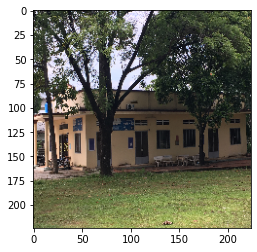

In [10]:
plt.imshow(X[199])
print(y[199])

#** tính chiều dài của features vector:
- pixels_per_cell(x,y): ảnh được chia ra thành các ô có số pixel là x*y
- cells_per_block(x,y): mỗi block chưa x*y ô pixels
- orientations : số hướng của vector đặc trưng

giả sử chúng ta có ảnh là 68 * 128 ( w * h), orientations = 9, pixels_per_cell(8,8), cells_per_block(3,3)
 
thì với số ô pixel có được là 8 * 16

với 16 ô pixel năm ở trục tung thì ta tính được có 14 vị trí các ô block
và 6 ô vị trí ở trục hoành

với mỗi vị trí thì ta tính được là 9 * 3 * 3 = 81 vector thành phần.

-> chiều dài của features vector : 81 * 14 * 6 = 6804


In [90]:
# from skimage.feature import hog
# from skimage import data, exposure
# image = cv2.imread('/content/dataset/B/IMG_1641.JPG', cv2.IMREAD_GRAYSCALE)
# a, hog_a = feature_extraction(image)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
# ax1.axis('off')
# ax1.imshow(image, cmap=plt.cm.gray)
# ax1.set_title('Input image')

# # Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_a, in_range=(0, 10))
# plt.figure(figsize=(8,4))
# ax2.axis('off')
# ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
# ax2.set_title('Histogram of Oriented Gradients')
# #plt.show()

In [91]:
# from skimage.feature import hog
# from skimage import data, exposure
# image = cv2.imread('/content/dataset/B/IMG_1641.JPG', cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, (128,64))
# fd = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), multichannel=True)
# #plt.imshow(fd)
# fd = np.array(fd)

In [11]:
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(X_features, y, test_size=0.25, shuffle=True, random_state=42)

#IV. Mô tả thuật toán máy học.

  - Sẽ sử dụng nhiều thuật toán classification khác nhau để có cái nhìn khác nhau về các thuật toán.
  Ví dụ: SVM classification, Decision Tree Classification, ...

##*Phân loại với model SVM classification

In [12]:
from sklearn.svm import SVC
SVCClassifier = SVC(C=3.5)
SVCClassifier.fit(X_train, y_train)

SVC(C=3.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
SVCClassifier.score(X_train, y_train)

1.0

In [14]:
SVCClassifier.score(X_test, y_test)

0.8009259259259259

In [15]:
ypred=SVCClassifier.predict(X_test)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           B       0.67      0.78      0.72        41
           C       0.74      0.74      0.74        38
          CT       0.86      0.78      0.82        41
           D       1.00      0.79      0.88        33
           E       0.82      0.87      0.85        63

    accuracy                           0.80       216
   macro avg       0.82      0.79      0.80       216
weighted avg       0.81      0.80      0.80       216



In [52]:
from joblib import dump
dump(SVCClassifier, 'SVC.joblib')

['SVC.joblib']

##* Linear SVC

In [53]:
from sklearn.svm import LinearSVC

Linear = LinearSVC(C=1.75, multi_class= "ovr")
Linear.fit(X_train, y_train)
LinearPred = Linear.predict(X_test)
print(classification_report(y_test, LinearPred))
#Linear.score(y_test, LinearPred)

              precision    recall  f1-score   support

           B       0.91      0.80      0.85        64
           C       0.80      0.85      0.82        52
          CT       0.64      0.62      0.63        29
           D       0.93      0.89      0.91        44
           E       0.78      0.87      0.82        68

    accuracy                           0.82       257
   macro avg       0.81      0.80      0.81       257
weighted avg       0.83      0.82      0.82       257



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [54]:
Linear.score(X_test, y_test)

0.8210116731517509

In [55]:
dump(Linear, 'LinearSVC.joblib')

['LinearSVC.joblib']

##* SGDClassifications

In [56]:
from sklearn.linear_model import SGDClassifier

SGD = SGDClassifier()
SGD.fit(X_train, y_train)
SGDpred = SGD.predict(X_test)
print(classification_report(y_test, SGDpred))
SGD.score(X_test, y_test)

              precision    recall  f1-score   support

           B       0.86      0.80      0.83        64
           C       0.62      0.90      0.73        52
          CT       0.62      0.62      0.62        29
           D       0.95      0.82      0.88        44
           E       0.87      0.71      0.78        68

    accuracy                           0.78       257
   macro avg       0.78      0.77      0.77       257
weighted avg       0.80      0.78      0.78       257



0.7782101167315175

In [57]:
dump(SGD, 'SGD.joblib')

['SGD.joblib']

#V. Cài đặt, Tinh chỉnh tham số

In [ ]:
from sklearn.svm import SVC
def turning(min_ep=1, max_ep=2):
    r = [x * 0.1 for x in range(10*min_ep, 10*max_ep)]
    mean = []
    for i in r:
        cf = SVC(C=i)
        cf.fit(X_train, y_train)  
        mean.append(cf.score(X_test, y_test))
    mean = np.array(mean)
    r = np.array(r)
    return mean, r
      

In [ ]:
#mean, r = turning(1,3)

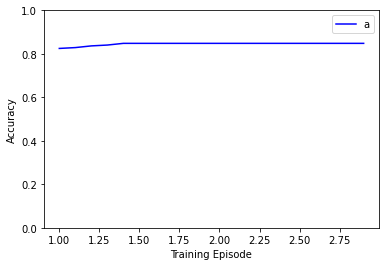

In [ ]:
# plt.xlabel('Training Episode')
# plt.ylabel('Accuracy')
# plt.ylim([0,1])
# plt.plot(r,mean, 'b-', label='a')
# plt.legend()

##* Xử dụng model cho một bức ảnh

In [ ]:
 def predict_one_image(path):
    img = cv2.imread(path, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (224,224))
    img = feature_extraction(img)
    #img = img/255
    img = img.reshape(1, img.shape[0])
    return img

In [ ]:
y_test.shape

(257,)

/content/dataset/C/IMG_1601(1).JPG
SVC ['C']
LinearSVC ['C']
SGDClassifier ['C']


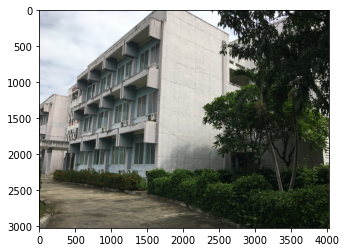

In [ ]:
path = input()
img = Image.open(path)
plt.imshow(img)
for clf in [SVCClassifier, Linear, SGD]:
  print(clf.__class__.__name__,clf.predict(predict_one_image(path)))

#*Xử lý trích xuất features bằng HOG và tăng cường cường độ của features

/content/dataset/E/103566043_894964134304526_808333282306241532_o.jpg


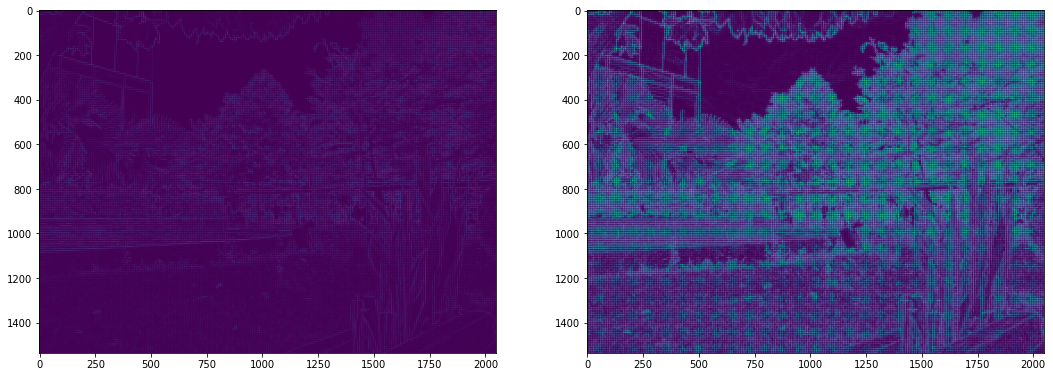

In [ ]:
img_path = input()
img = Image.open(img_path)
_, hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True, visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
f, a = plt.subplots(1,2, figsize=(18,18))
a[0].imshow(hog_img)
a[1].imshow(hog_image_rescaled)  

In [10]:
def exposure_hog(img):
    ft, hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True, visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
    features = image.img_to_array(hog_image_rescaled)
    return features

In [11]:
def exposure_features(data):
    features = []
    for image in data:
      f = exposure_hog(image)
      features.append(f)
    return features

In [ ]:
X_hog = exposure_features(X)
X_hog = np.asarray(X_hog)
X_hog.shape

(1025, 224, 224, 1)

In [ ]:
X_hog = X_hog.reshape(X_hog.shape[0], X_hog.shape[1]*X_hog.shape[2])

In [ ]:
(Xhog_train, Xhog_test, yhog_train, yhog_test) = train_test_split(X_hog, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
clf = SVC(C=2.8)
clf.fit(Xhog_train, yhog_train)
print(clf.score(Xhog_test, yhog_test))
yhogpred=clf.predict(Xhog_test)

print(classification_report(yhog_test, yhogpred))

0.8249027237354085
              precision    recall  f1-score   support

           B       0.84      0.86      0.85        63
           C       0.80      0.81      0.80        58
          CT       0.78      0.78      0.78        36
           D       0.91      0.89      0.90        36
           E       0.81      0.80      0.80        64

    accuracy                           0.82       257
   macro avg       0.83      0.83      0.83       257
weighted avg       0.83      0.82      0.83       257



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(yhog_test, yhogpred))

[[54  2  2  0  5]
 [ 1 47  2  2  6]
 [ 7  0 28  0  1]
 [ 0  3  1 32  0]
 [ 2  7  3  1 51]]


In [ ]:
from sklearn.svm import SVC
def turning(min_ep=1, max_ep=2):
    r = [x * 0.1 for x in range(10*min_ep, 10*max_ep)]
    mean = []
    for i in r:
        cf = SVC(C=i)
        cf.fit(Xhog_train, yhog_train)  
        mean.append(cf.score(Xhog_test, yhog_test))
    mean = np.array(mean)
    r = np.array(r)
    return mean, r
mean, r = turning(1,4)   

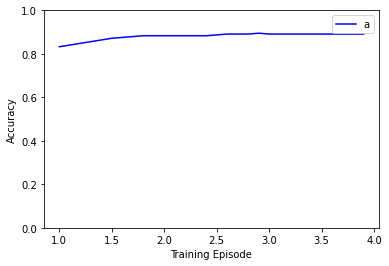

In [ ]:
plt.xlabel('Training Episode')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.plot(r,mean, 'b-', label='a')
plt.legend()

In [ ]:
from joblib import dump
dump(clf, 'hogSVC.joblib')

['hogSVC.joblib']

#*VI. Đánh giá kết quả, kết luật
- Bài toán 

In [2]:
from joblib import load

In [17]:
clf = load('/content/drive/My Drive/SVC.joblib')

In [18]:
from PIL import Image
import requests
from io import BytesIO
url = input()
resp = requests.get(url, stream=True).raw
img = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.imread(path, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(224,224))
plt.imshow(img)
img = exposure_hog(img)
img = img.reshape(1, img.shape[0]*img.shape[1])
print(clf.__class__.__name__,clf.predict(img))


/content/drive/My Drive/SVC.joblib


MissingSchema: ignored

In [18]:
testX, testy = load_images_from_folder('/content/drive/My Drive/Dataset Đồ án ML/testset')

In [19]:
f_X = get_feature(testX)
f_X = np.asarray(f_X)
# testX = testX.reshape(testX.shape[0], testX.shape[1]*testX.shape[2])
f_X.shape

(380, 26244)

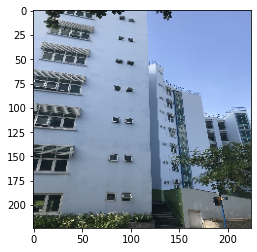

In [22]:
plt.imshow(testX[1])

In [20]:
pred = SVCClassifier.predict(f_X)
print(SVCClassifier.score(f_X, testy))
print(classification_report(testy, pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(testy, pred))

0.6736842105263158
              precision    recall  f1-score   support

           B       0.63      0.46      0.53        79
           C       0.60      0.36      0.45        76
          CT       0.75      0.92      0.83        75
           D       1.00      0.95      0.97        79
           E       0.44      0.69      0.54        71

    accuracy                           0.67       380
   macro avg       0.68      0.67      0.66       380
weighted avg       0.69      0.67      0.67       380

[[36  4  7  0 32]
 [10 27 14  0 25]
 [ 0  5 69  0  1]
 [ 0  0  0 75  4]
 [11  9  2  0 49]]
